# Feature extraction from Histology Images

Click to open in: \[[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/11-feature-extraction.ipynb)\]\[[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/develop/examples/11-feature-extraction.ipynb)\]



## About this notebook

This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

## About this demo

In this example, we will show how to extract features from a pretrained PyTorch model that exists outside TIAToolbox, using the WSI inference engines provided by TIAToolbox.

## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [10]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


  Running command git clone --filter=blob:none --quiet https://github.com/TissueImageAnalytics/tiatoolbox.git /tmp/pip-req-build-gk3bazjw


Installation is done.


**IMPORTANT**: When you run the cell above for the first time, while using Colab, you need to restart the runtime before proceeding further. Click on the box *RESTART RUNTIME* that appears immediately above this cell, or use the menu *Runtime→Restart runtime*. This loads the latest versions of prerequisite packages. The notebook can then be managed normally. For example, you can run subsequent cells one by one, or you can click on *Runtime→Run all* or *Runtime→after*.



### Importing related libraries

We will start by importing some libraries required to run this notebook.



In [11]:
"""Import modules required to run the Jupyter notebook."""

# Clear logger to use tiatoolbox.logger
import logging
import warnings

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# Downloading data and files
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import requests

# Data processing and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import contextlib
import io

# TIAToolbox for WSI loading and processing
from tiatoolbox import logger
from tiatoolbox.models.architecture import vanilla
from tiatoolbox.models.engine.semantic_segmentor import DeepFeatureExtractor, IOSegmentorConfig
from tiatoolbox.utils.misc import download_data
from tiatoolbox.wsicore.wsireader import WSIReader

# Import some extra modules
import umap

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

# Function to suppress console output for overly verbose code blocks
def suppress_console_output():
    return contextlib.redirect_stderr(io.StringIO())

|2024-11-29|10:25:41.490| [WARNING] /home/u1973415/miniforge3/envs/tiatoolbox-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



### GPU or CPU runtime

Processes in this notebook can be accelerated by using a GPU. Therefore, whether you are running this notebook on your system or Colab, you need to check and specify if you are using GPU or CPU hardware acceleration. In Colab, you need to make sure that the runtime type is set to GPU in the *"Runtime→Change runtime type→Hardware accelerator"*. If you are *not* using GPU, consider changing the `ON_GPU` flag to `Flase` value, otherwise, some errors will be raised when running the following cells.



In [12]:
ON_GPU = True  # Should be changed to False if no cuda-enabled GPU is available

### Removing leftovers from previous runs

This cell removes the directory `tmp` if it exists—a previous run may have created it. This cell can be skipped if you are running this notebook for the first time.



In [20]:
![ -d tmp ] && ( echo "deleting tmp directory"; rm -rf tmp )

### Downloading the required files

We download, over the internet, a histology whole slide image of cancerous breast tissue samples to show how the feature extractor works. Download is needed once in each Colab session.

> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 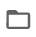


In [ ]:
warnings.filterwarnings("ignore")
global_save_dir = Path("tmp/")

# File name of WSI
wsi_path = global_save_dir / "sample_wsi.svs"

logger.info("Download has started. Please wait...")

# Downloading and unzip a sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs",
    wsi_path,
)

logger.info("Download is complete.")

|2024-11-29|10:28:10.395| [INFO] Download has started. Please wait...
|2024-11-29|10:28:22.881| [INFO] Download is complete.


## Feature extraction using pretrained (foundation) models

In this section, we extract deep features using various CNN/transformer backbones. These features could be used to train a downstream model.

We first create the model using pretrained network architectures. For standard CNN model architectures available with PyTorch (e.g. AlexNet, ResNet, DenseNet, Inception, etc.) the use `CNNBackbone`. For other models available with Timm, such as Computational Pathology specific models. use `TimmBackbone` (e.g. EfficientNet, UNI, Prov-GigaPath).

We also provide an `IOSegmentorConfig' specifying the input/output patch shape and resolution for processing and saving the output.

Finally, we use the `DeepFeatureExtractor` to extract these deep features, per patch, from the WSI. A mask is automatically generated to gudie the patch extraction process (and to ignore background).

In [22]:
model = vanilla.CNNBackbone("resnet50")
# model = vanilla.TimmBackbone("efficientnet_b0", pretrained=True)

wsi_ioconfig = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    output_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_output_shape=[224, 224],
    stride_shape=[224, 224],
)

# create the feature extractor and run it on the WSI
extractor = DeepFeatureExtractor(
    model=model, 
    auto_generate_mask=True, 
    batch_size=32, 
    num_loader_workers=4, 
    num_postproc_workers=4
    )

with suppress_console_output():
    out = extractor.predict(
        imgs=[wsi_path],
        mode="wsi", 
        ioconfig=wsi_ioconfig, 
        save_dir=global_save_dir / "wsi_features",
        )

|2024-11-29|10:28:36.752| [WARNING] GPU is not compatible with torch.compile. Compatible GPUs include NVIDIA V100, A100, and H100. Speedup numbers may be lower than expected.
|2024-11-29|10:28:36.754| [WARNING] ('torch-compile is currently not supported in Python 3.12+. ',)
|2024-11-29|10:28:36.848| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


|2024-11-29|10:36:37.028| [INFO] Finish: 0
|2024-11-29|10:36:37.030| [INFO] --Input: ../tmp/sample_wsi.svs
|2024-11-29|10:36:37.030| [INFO] --Output: /newdata/u1973415/TIAToolbox/tmp/wsi_features/0


## Post-processing and Visualisation

These deep features could be used to train a downstream model, but in this section, in order to get some intuition for what the features represent, we will use a UMAP reduction to visualise the features in RGB space. The points labelled in a similar colour should have similar features, so we can check if the features naturally separate out into the different tissue regions when we overlay the UMAP reduction on the WSI thumbnail.

In the output above, the method returns a list of the paths to its inputs and to the processed outputs saved on the disk. This can be used to load the results for processing and visualisation.

Text(0.5, 1.0, 'UMAP reduction of features')

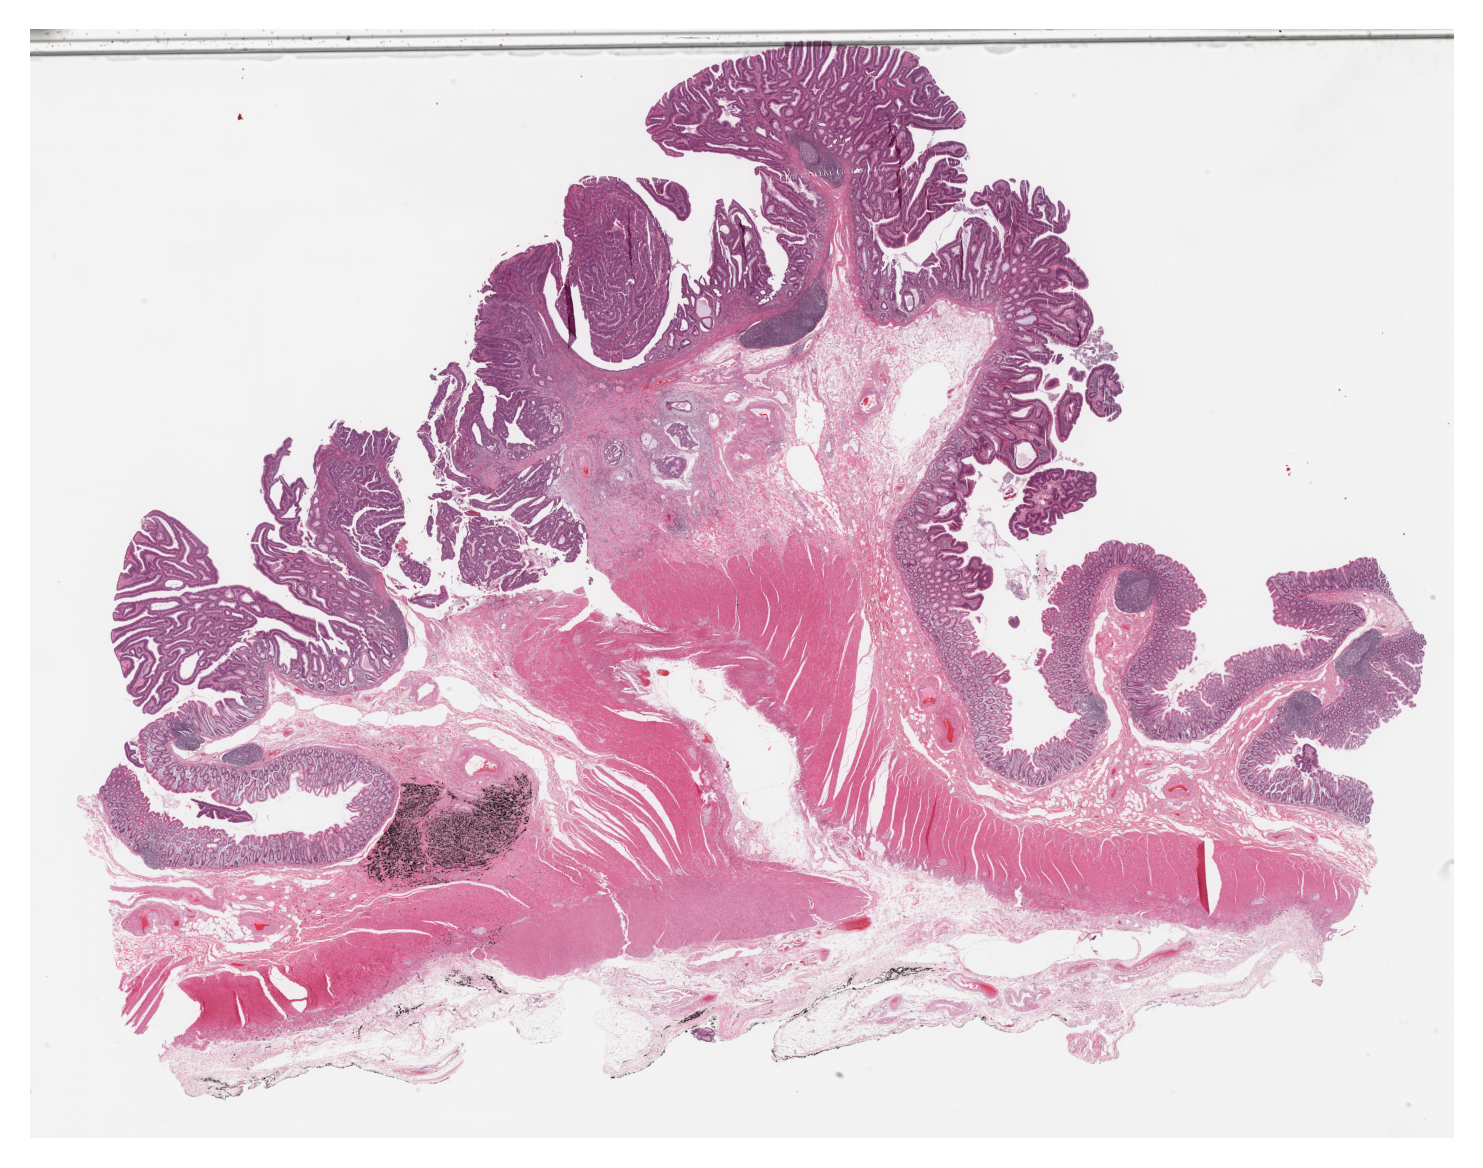

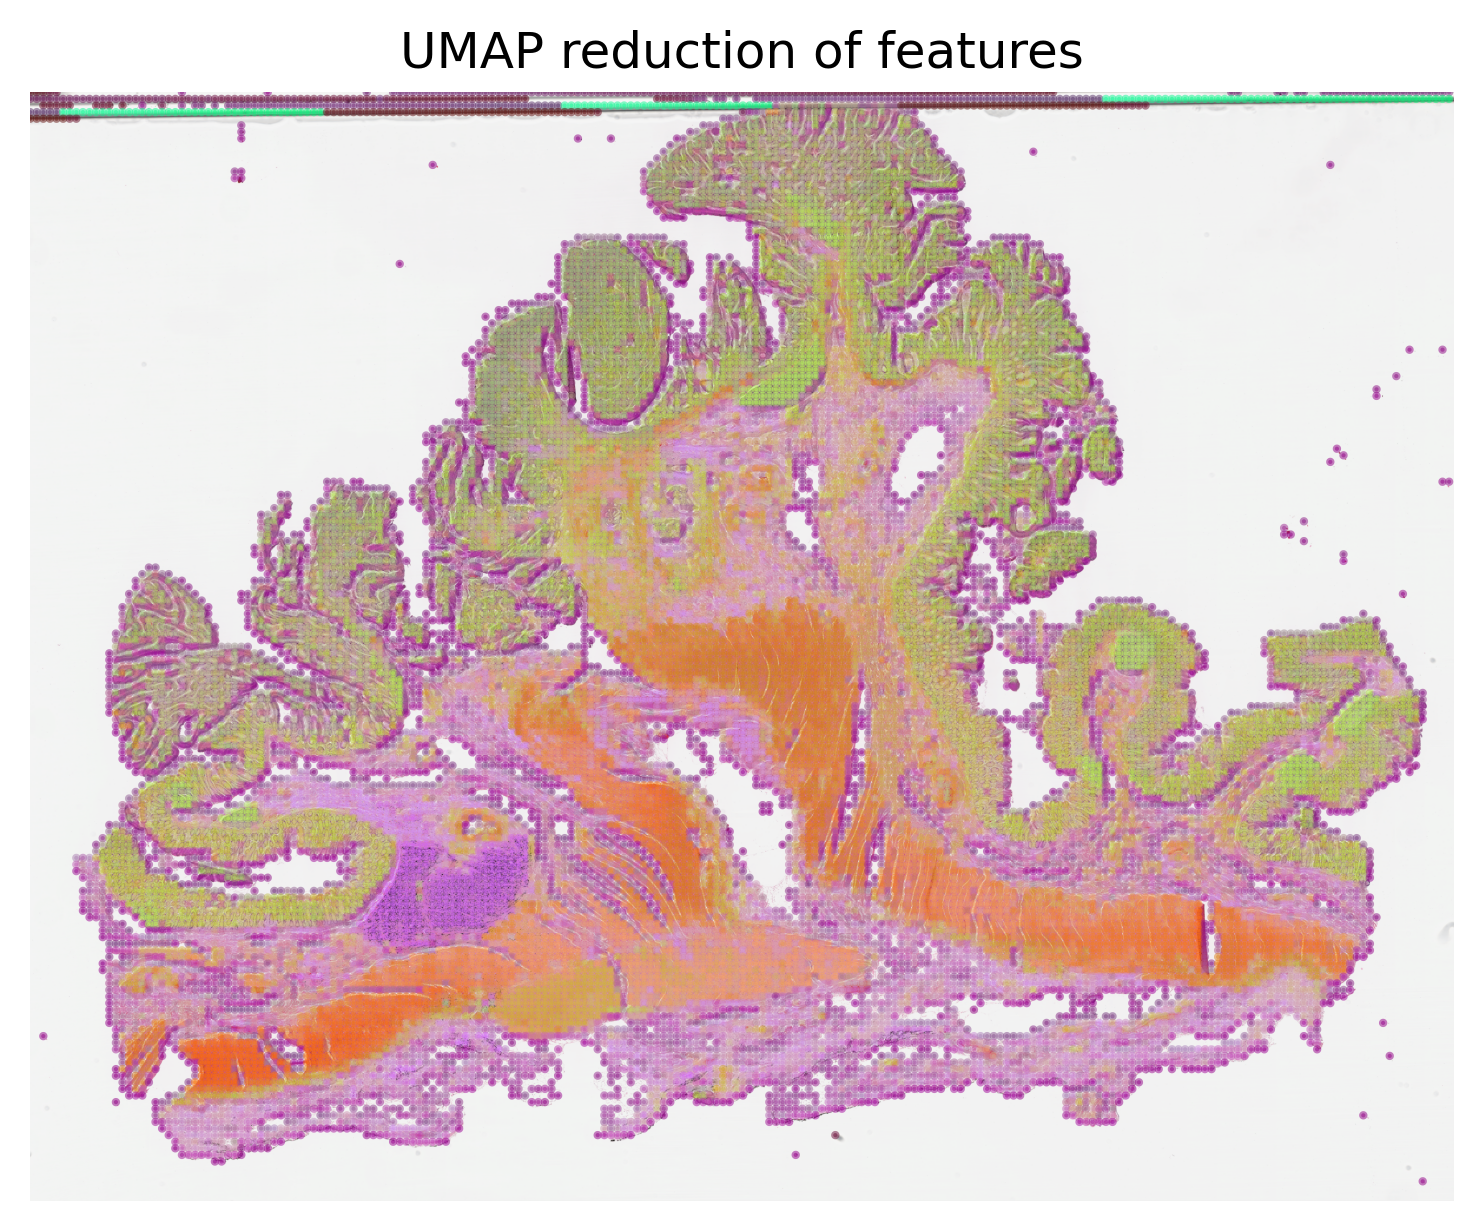

In [23]:
# First we define a function to calculate the umap reduction
def umap_reducer(x, dims=3, nns=10):
    """UMAP reduction of the input data."""
    reducer = umap.UMAP(n_neighbors=nns, n_components=dims, metric="manhattan", spread=0.5, random_state=2)
    reduced = reducer.fit_transform(x)
    reduced -= reduced.min(axis=0)
    reduced /= reduced.max(axis=0)
    return reduced

# load the features output by our feature extractor
pos = np.load(global_save_dir / "wsi_features" / "0.position.npy")
feats = np.load(global_save_dir / "wsi_features" / "0.features.0.npy")
pos = pos / 8 # as we extracted at 0.5mpp, and we are overlaying on a thumbnail at 4mpp

# reduce the features into 3 dimensional (rgb) space
reduced = umap_reducer(feats)

overview_resolution = (
    4  # the resolution in which we desire to merge and visualise the patch predictions
)
# the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
overview_unit = "mpp"
wsi = WSIReader.open(wsi_path)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview)
plt.axis("off")
# plt.show()

# plot the feature map reduction
plt.figure()
plt.imshow(wsi_overview)
plt.scatter(pos[:,0], pos[:,1], c=reduced, s=1, alpha=0.5)
plt.axis("off")
plt.title("UMAP reduction of features")
# plt.show()

We see that the feature map from our feature encoder, capture similar information about the tissue types in the WSI, since different tissue types appear to have different colours. This is a good sanity check that our models are working as expected.